In [3]:
%config StoreMagics.autorestore = True
%reset -f
# %store -z
%store -r
%whos

Variable                     Type              Data/Info
--------------------------------------------------------
PDMultiOrderROM_results      list              n=2160
Tsam                         float             0.75
fullOrder                    int               80
hatMathcalPcl                LinearIOSystem    <LinearIOSystem>: sys[55]<...> 0.000e+00  0.000e+00]]\n
hatMathcalPext               LinearIOSystem    <LinearIOSystem>: sys[44]<...> [0. 0.]\n     [0. 0.]]\n
hsvMathcalPext               ndarray           80: 80 elems, type `float64`, 640 bytes
mathcalC                     StateSpace        A = [[-100.]]\n\nB = [[1.<...>[[-8.]]\n\nD = [[0.08]]\n
mathcalEext                  LinearICSystem    <LinearICSystem>: sys[51]<...> [0. 0.]\n     [0. 0.]]\n
mathcalP                     LinearIOSystem    <LinearIOSystem>: sys[2]\<...>[[0. 0.]\n     [0. 0.]]\n
mathcalPcl                   LinearIOSystem    <LinearIOSystem>: sys[50]<...>[[0. 0.]\n     [0. 0.]]\n
mathcalPext              

In [4]:
import numpy
import sympy
import scipy
import control
import matplotlib.pyplot as plt

from custom_utils import ControlUtils
from custom_utils import ODEUtils

from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML

numpy.set_printoptions(precision=3)
sympy.init_printing(use_latex='mathjax', use_unicode=True)
sympy.init_printing()
plt.rcParams.update({ "text.usetex": True, "font.family": "Helvetica", "axes.titley": 1.0 })
%matplotlib inline

In [5]:
# Simulation parameters
T_step = Tsam/1000
t_ini = 0
t_fin = 5
steps = int(numpy.ceil((t_fin-t_ini)/T_step))

tkVec = numpy.arange(t_ini, t_fin, Tsam)[:, None]
tVec = numpy.linspace(t_ini, t_fin, steps)[:, None]
# uVec = 1e-4*numpy.sin(2*numpy.pi*tVec/0.1)
uVec = 1*numpy.sin(15*tVec)
zerosVec = 0*numpy.zeros((steps,1))


In [6]:
# FOM
resultFOM = control.input_output_response(mathcalPcl, tVec.reshape(-1),numpy.column_stack([zerosVec,uVec]).T,\
                                        numpy.zeros((mathcalPcl.A.shape[0],1)),t_eval=tVec.reshape(-1))

In [7]:
# ROM
resultROM = control.input_output_response(hatMathcalPcl, tVec.reshape(-1),numpy.column_stack([zerosVec,uVec]).T,\
                                        numpy.zeros((hatMathcalPcl.A.shape[0],1)),t_eval=tVec.reshape(-1))

In [8]:
# Sampled FOM
xpVecFOM, xcVecFOM, vsVecFOM, whVecFOM = ODEUtils.solveSDLinearSystem(plant=mathcalPext,
                                                          discrete_controller=overlineMathcalC,
                                                          xp0=0*numpy.random.rand(*(mathcalPext.A.shape[0], 1)),
                                                          xc0=0*numpy.random.rand(*(overlineMathcalC.A.shape[0], 1)),
                                                          uVec=uVec, t_ini=t_ini, t_fin=t_fin, T_step=T_step, T_samps=tkVec)

In [9]:
# Sampled ROM
xpVecROM, xcVecROM, vsVecROM, whVecROM = ODEUtils.solveSDLinearSystem(plant=hatMathcalPext,
                                                          discrete_controller=overlineMathcalC,
                                                          xp0=0*numpy.random.rand(*(hatMathcalPext.A.shape[0], 1)),
                                                          xc0=0*numpy.random.rand(*(overlineMathcalC.A.shape[0], 1)),
                                                          uVec=uVec, t_ini=t_ini, t_fin=t_fin, T_step=T_step, T_samps=tkVec)

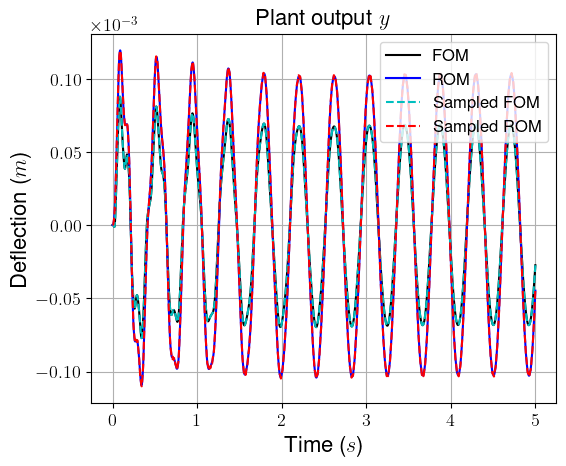

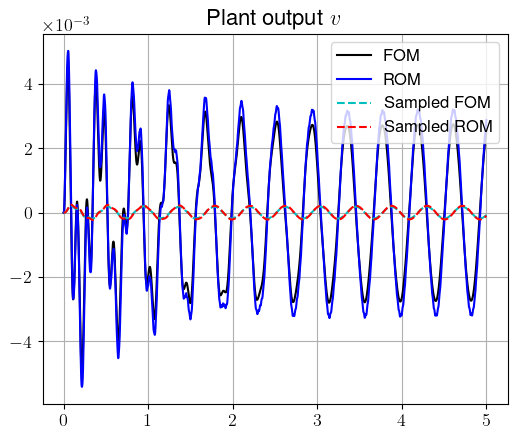

In [11]:
# Compute outputs
tLims = [t_ini,t_fin]
idxLims = range(numpy.where(tVec[:, 0] >= tLims[0])[0][0], numpy.where(tVec[:, 0] >= tLims[1])[0][0] + 1)

yVecFOM = resultFOM.outputs[1][:,None].T
vVecFOM = resultFOM.outputs[0][:,None].T

yVecROM = resultROM.outputs[1][:,None].T
vVecROM = resultROM.outputs[0][:,None].T

yVecSampledFOM = mathcalPext.C[-1:,:] @ xpVecFOM
vVecSampledFOM = mathcalPext.C[0:1,:] @ xpVecFOM

yVecSampledROM = hatMathcalPext.C[-1:,:] @ xpVecROM
vVecSampledROM = hatMathcalPext.C[0:1,:] @ xpVecROM

plt.plot(tVec[idxLims, 0], yVecFOM[0, idxLims], 'k', label="FOM", linestyle='solid')
plt.plot(tVec[idxLims, 0], yVecROM[0, idxLims], 'b', label="ROM", linestyle='solid')
plt.plot(tVec[idxLims, 0], yVecSampledFOM[0, idxLims], 'c', label="Sampled FOM", linestyle='dashed')
plt.plot(tVec[idxLims, 0], yVecSampledROM[0, idxLims], 'r', label="Sampled ROM", linestyle='dashed')
plt.ticklabel_format(axis='y', scilimits=(-3,-3))
plt.tick_params(axis='y', labelsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.gca().yaxis.get_offset_text().set_fontsize(13)
plt.gca().xaxis.get_offset_text().set_fontsize(13)
plt.title('Plant output $y$', fontsize=16)
plt.ylabel('Deflection ($m$)', fontsize=16)
plt.xlabel('Time ($s$)', fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.grid()
plt.gcf().set_figwidth(6)
plt.savefig('ode_simulation_comparison.png', format='png', transparent=True, bbox_inches="tight", pad_inches=0.1)
plt.show()
        
plt.plot(tVec[idxLims, 0], vVecFOM[0, idxLims], 'k', label="FOM", linestyle='solid')
plt.plot(tVec[idxLims, 0], vVecROM[0, idxLims], 'b', label="ROM", linestyle='solid')
plt.plot(tVec[idxLims, 0], vVecSampledFOM[0, idxLims], 'c', label="Sampled FOM", linestyle='dashed')
plt.plot(tVec[idxLims, 0], vVecSampledROM[0, idxLims], 'r', label="Sampled ROM", linestyle='dashed')
plt.ticklabel_format(axis='y', scilimits=(-3,-3))
plt.tick_params(axis='y', labelsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.gca().yaxis.get_offset_text().set_fontsize(13)
plt.gca().xaxis.get_offset_text().set_fontsize(13)
plt.title('Plant output $v$', fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.grid()
plt.gcf().set_figwidth(6)
plt.show()